# [Curso de aprendizagem por reforço](https://www.udemy.com/course/inteligencia-artificial-empresas-negocios/): Deep Q-Learning

* Estudo de Caso 2
    * Minimizando Custos de Consumo de 
    * Energia de um Data Center


### Parâmetros do servidor:

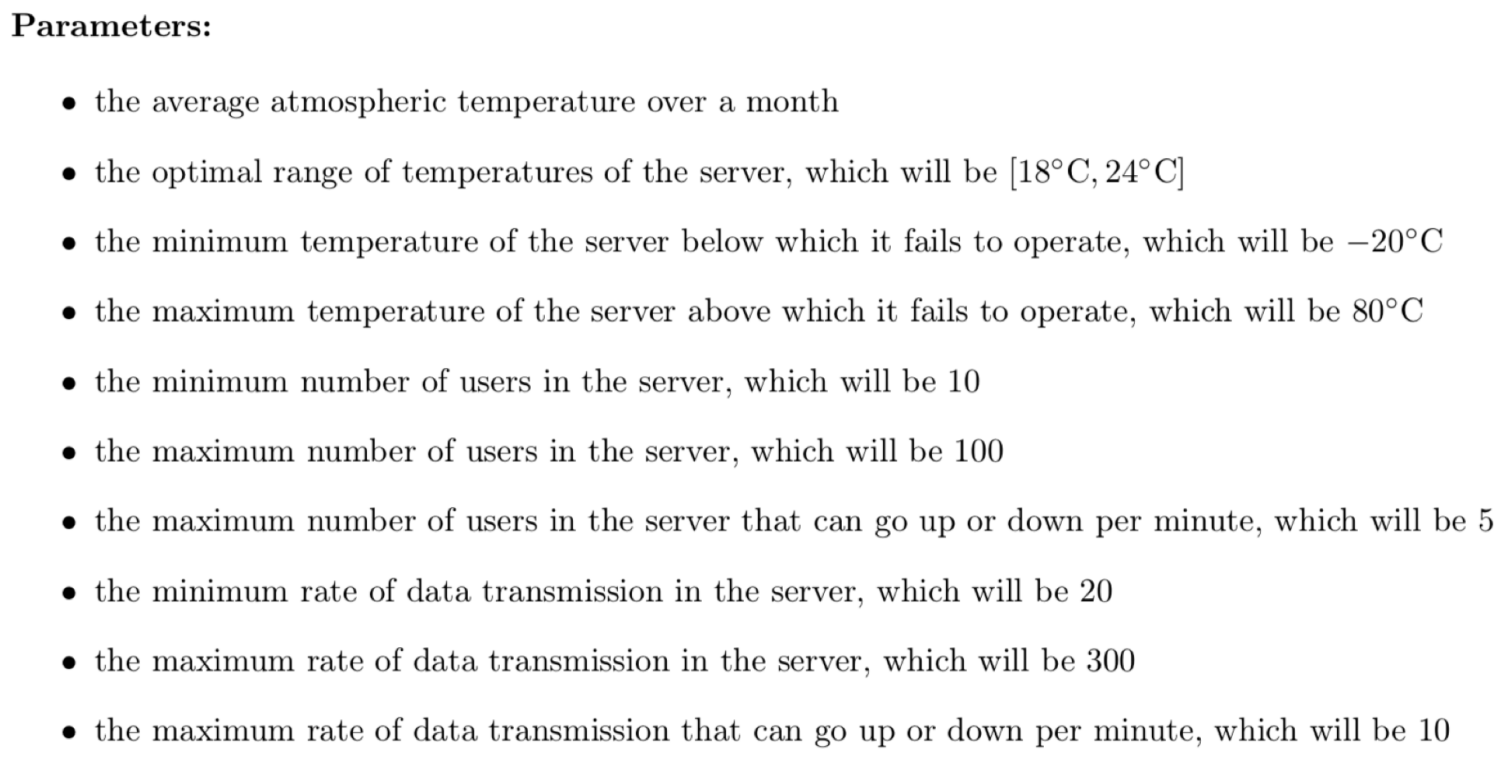

### Variaveis:

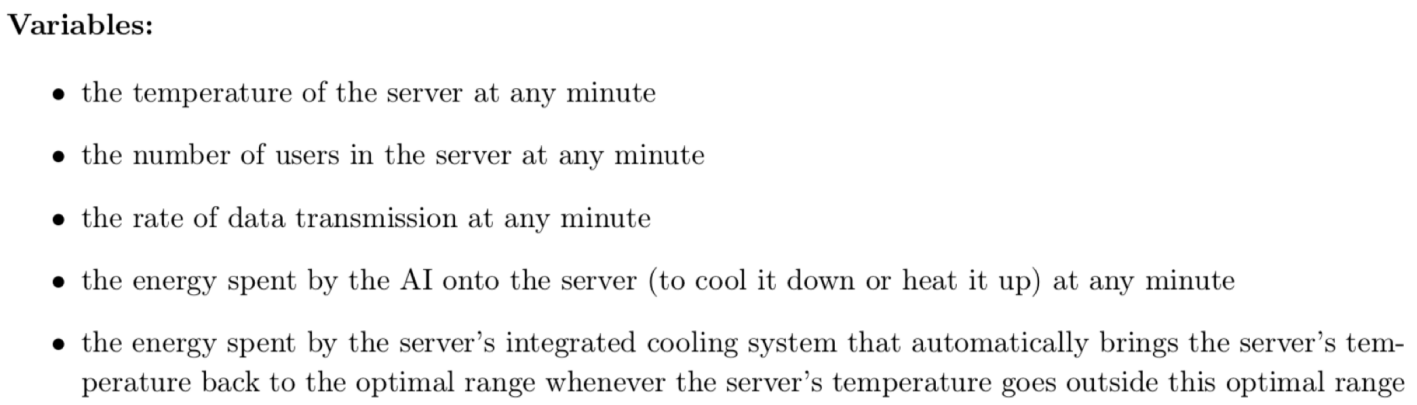

### O calculo da variável intrinsic_temperature está explicado abaixo:

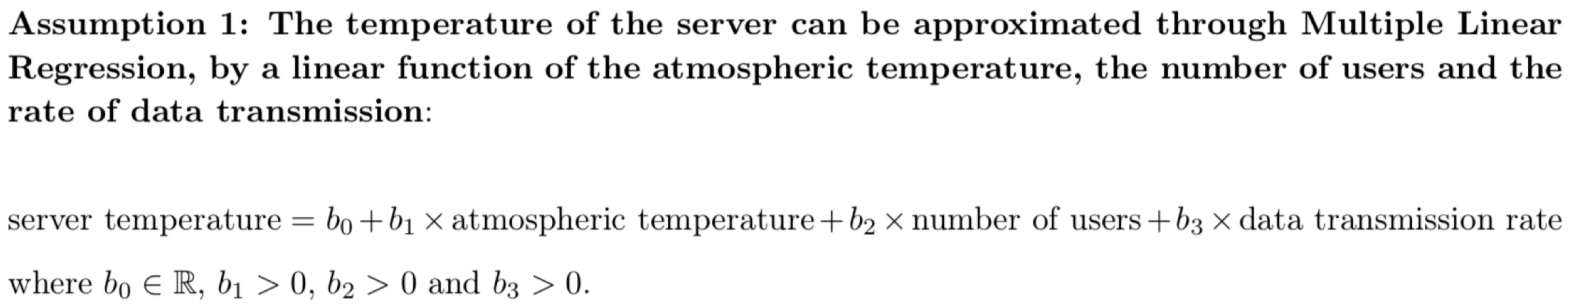

### O calculo da variável energy_noai extá explicado abaixo:

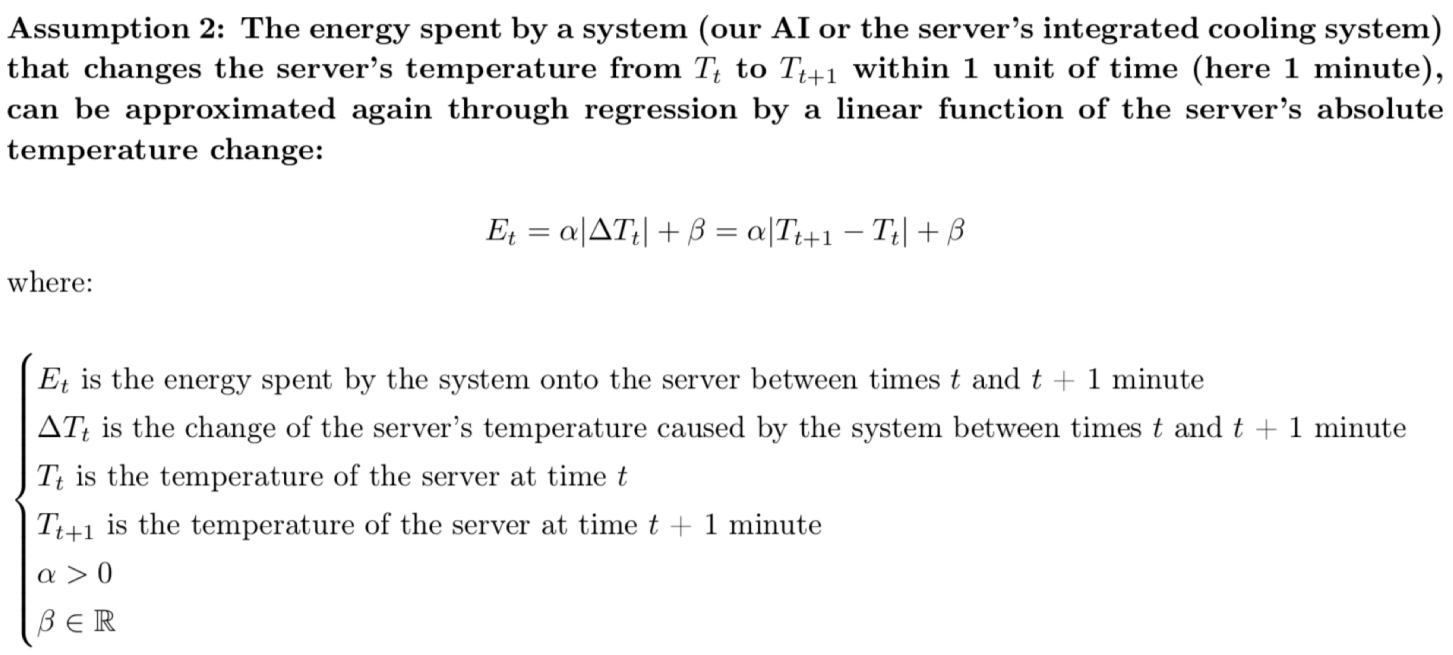
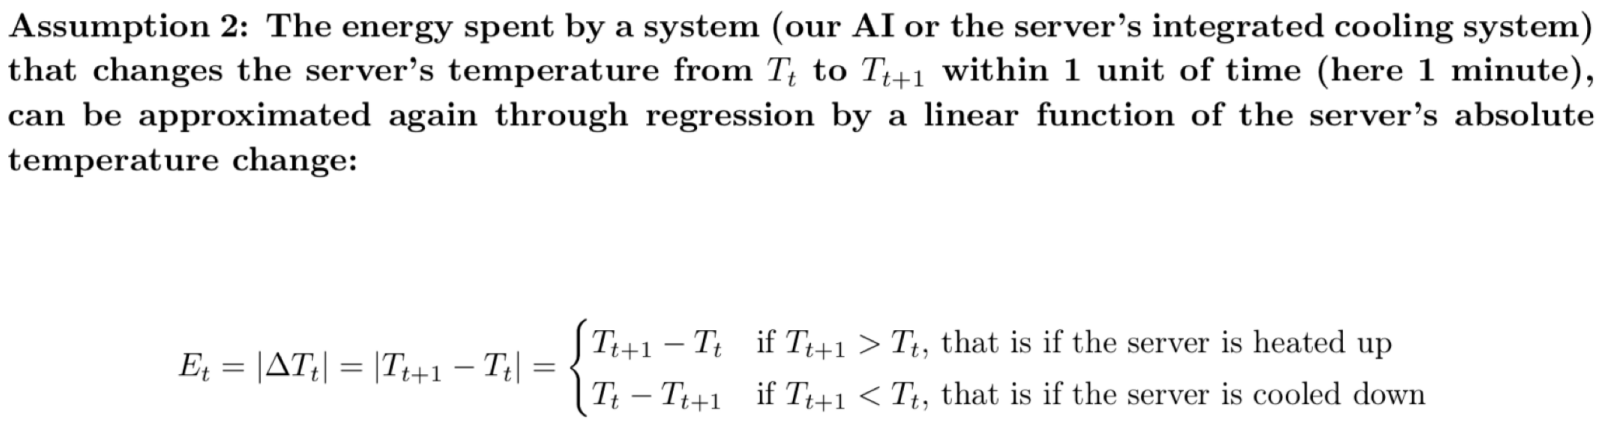

### Definição da recompensa R (reward)

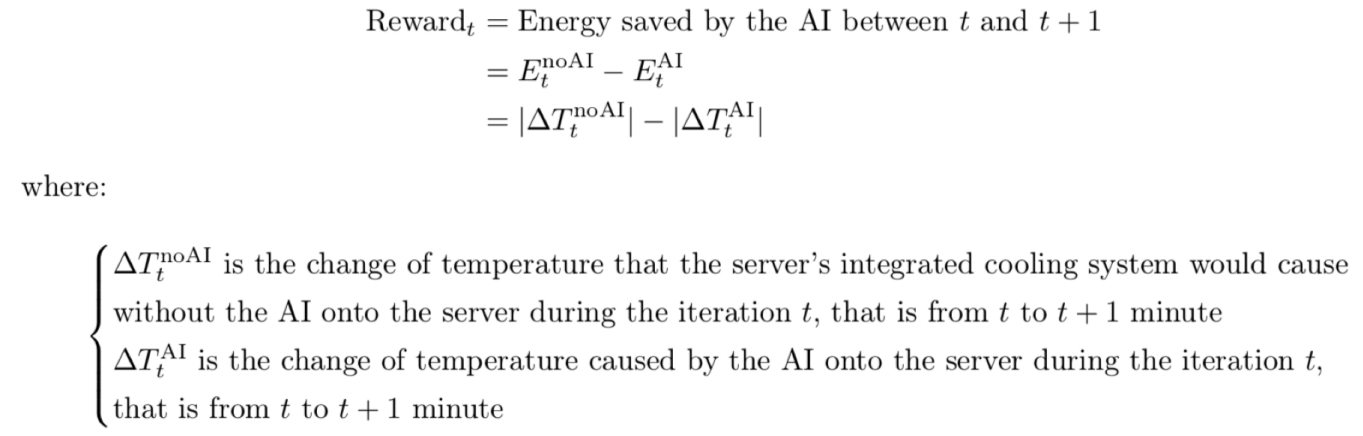

### Ilustração dos inputs para a rede neural e seus outputs (softmax)

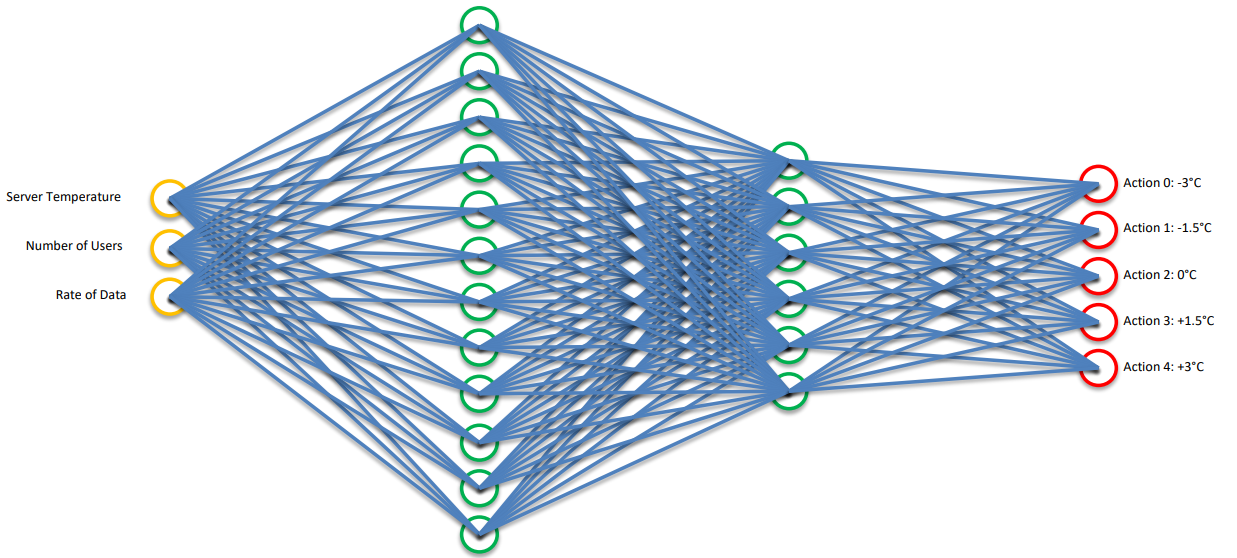

In [1]:
import numpy as np


class Environment:

    _REWARD_SCALER = 1e-3
    
    def __init__(self, 
                 optimal_temperature = (18.0, 24.0),
                 initial_month = 0,
                 initial_number_users = 10,
                 initial_rate_data = 60):
        """
        The environment of the server to minimze the cost
        """
        self.optimal_temperature = optimal_temperature
        self.initial_month = initial_month
        self.initial_number_users = initial_number_users
        self.current_number_users = initial_number_users
        self.initial_rate_data = initial_rate_data
        self.current_rate_data = initial_rate_data
        self.monthly_atmospheric_temperature = [1.0, 5.0, 7.0, 10.0, 11.0, 20.0, 23.0, 24.0, 22.0, 10.0, 5.0, 1.0]
        self.atmospheric_temperature = self.monthly_atmospheric_temperature[initial_month]
        self.min_temperature = -20
        self.max_temperature = 80
        self.min_number_users = 10
        self.max_number_users = 100
        self.max_update_users = 5
        self.min_rate_data = 20
        self.max_rate_data = 300
        self.max_update_data = 10
        # It's the optimization found using Linear Regression, explained above
        self.intrinsic_temperature = self.atmospheric_temperature + 1.25 * self.current_number_users + 1.25 * self.current_rate_data
        # The variable temperature_ai will be used to find the "best" optimization
        self.temperature_ai = self.intrinsic_temperature
        min_optimal, max_optimal = self.optimal_temperature
        # It's the manual optimization
        self.temperature_noai = (min_optimal + max_optimal) / 2.0
        self.total_energy_ai = 0.0
        self.total_energy_noai = 0.0
        self.reward = 0.0
        self.game_over = False
        self.train = True

    def update_env(self, direction, energy_ai, month: int):

        # OBTENDO A RECOMPENSA

        # Calculo de energia gasta quando não tem AI
        energy_noai = 0
        min_optimal_temperature, max_optimal_temperature = self.optimal_temperature
        if self.temperature_noai < min_optimal_temperature:
            energy_noai = min_optimal_temperature - self.temperature_noai
            self.temperature_noai = min_optimal_temperature
        elif self.temperature_noai > max_optimal_temperature:
            energy_noai = self.temperature_noai - max_optimal_temperature
            self.temperature_noai = max_optimal_temperature

        # Calculo da recompensa
        self.reward = energy_noai - energy_ai

        # Escalonamento da recompensa (recomendado em artigos ciêntificos, para facilitar o calculo)
        self.reward = self._REWARD_SCALER * self.reward

        # OBTENDO O PRÓXIMO ESTADO

        # Atualização da temperatura atmosférica
        self.atmospheric_temperature = self.monthly_atmospheric_temperature[month]

        # Atualização do número de usuários (simulação, esse valor seria retornado por alguma API por exemplo)
        self.current_number_users += np.random.randint(-self.max_update_users, self.max_update_users)
        if self.current_number_users < self.min_number_users:
            self.current_number_users = self.min_number_users
        elif self.current_number_users > self.max_number_users:
            self.current_number_users = self.max_number_users

        # Atualização da taxa de transmissão
        self.current_rate_data += np.random.randint(-self.max_update_data, self.max_update_data)
        if self.current_rate_data < self.min_rate_data:
            self.current_rate_data = self.min_rate_data
        elif self.current_rate_data > self.max_rate_data:
            self.current_rate_data = self.max_rate_data

        # Calculo do delta da temperatura intrinsica
        past_intrinsic_temperature = self.intrinsic_temperature
        self.intrinsic_temperature = self.atmospheric_temperature + 1.25 * self.current_number_users + 1.25 * self.current_rate_data
        delta_intrinsic_temperature = self.intrinsic_temperature - past_intrinsic_temperature
        
        # Calculo do delta da temperatura regulada por IA
        if direction == -1:
            delta_temperature_ai = -energy_ai
        elif direction == 1:
            delta_temperature_ai = energy_ai

        # Atualização da nova temperatura do servidor quando tem IA
        self.temperature_ai += delta_intrinsic_temperature + delta_temperature_ai
            
        # Atualização da nova temperatura do servidor quanto não tem IA
        self.temperature_noai += delta_intrinsic_temperature

        # VERIFICAÇÃO FINAL (GAME OVER)
        if self.temperature_ai < self.min_temperature:
            if self.train == 1:
                self.game_over = 1
            else:
                self.temperature_ai = self.optimal_temperature[0]
                self.total_energy_ai += self.optimal_temperature[0] - self.temperature_ai
        elif self.temperature_ai > self.max_temperature:
            if self.train == 1:
                self.game_over = 1
            else:
                self.temperature_ai = self.optimal_temperature[0]
                self.total_energy_ai += self.temperature_ai - self.optimal_temperature[0]

        # ATUALIZAÇÃO DOS OBJETIVOS

        # Atualização do total de energia gasta pela IA
        self.total_energy_ai += energy_ai

        # Atualização do total de energia gasta quando não tem IA
        self.total_energy_noai += energy_noai

        # ESCALONAMENTO DE VALORES

        scaled_temperature_ai = (self.temperature_ai - self.min_temperature) / (self.max_temperature - self.min_temperature)
        scaled_number_users = (self.current_number_users - self.min_number_users) / (self.max_number_users - self.min_number_users)
        scaled_rate_data = (self.current_rate_data - self.min_rate_data) / (self.max_rate_data - self.min_rate_data)
        next_state = np.matrix([scaled_temperature_ai, scaled_number_users, scaled_rate_data])

        # RETORNO DO PRÓXIMO ESTADO, DA RECOMPENSA E DO GAME OVER
        return next_state, self.reward, self.game_over

    # FUNÇÃO PARA RESETAR OU INICIAR O AMBIENTE
    def reset(self, new_month: int):
        self.atmospheric_temperature = self.monthly_atmospheric_temperature[new_month]
        self.initial_month = new_month
        self.current_number_users = self.initial_number_users
        self.current_rate_data = self.initial_rate_data
        self.intrinsic_temperature = self.atmospheric_temperature + 1.25 * self.current_number_users + 1.25 * self.current_rate_data
        self.temperature_ai = self.intrinsic_temperature
        min_optimal, max_optimal = self.optimal_temperature
        self.temperature_noai = (min_optimal + max_optimal) / 2.0
        self.total_energy_ai = 0.0
        self.total_energy_noai = 0.0
        self.reward = 0.0
        self.game_over = False
        self.train = True

    # FUNÇÃO PARA RETORNAR O ESTADO ATUAL, A ULTIMA RECOMPENSA E SE É GAME OVER
    def observe(self):
        scaled_temperature_ai = (self.temperature_ai - self.min_temperature) / (self.max_temperature - self.min_temperature)
        scaled_number_users = (self.current_number_users - self.min_number_users) / (self.max_number_users - self.min_number_users)
        scaled_rate_data = (self.current_rate_data - self.min_rate_data) / (self.max_rate_data - self.min_rate_data)
        current_state = np.matrix([scaled_temperature_ai, scaled_number_users, scaled_rate_data])
        return current_state, self.reward, self.game_over


In [2]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam


class Brain(object):
    
    # CONSTRUÇÃO DA ARQUITETURA DA REDE NEURAL DENSA DENTRO DO MÉTODO FIT
    def __init__(self, learning_rate=0.001, number_actions=5):
        self.learning_rate = learning_rate
        
        # CRIAÇÃO DA CAMADA DE ENTRADA COMPOSTA PELO INPUT STATE
        states = Input(shape=(3,))
        
        # CRIAÇÃO DAS CAMADAS OCULTAS DA REDE NEURAL DENSA
        x = Dense(units=64, activation="sigmoid")(states)
        y = Dense(units=32, activation="sigmoid")(x)

        # CRIAÇÃO DA CAMADA DE SAÍDA, CONECTADA COM A ULTIMA CAMADA OCULTA
        q_values = Dense(units=number_actions, activation="softmax")(y)

        # AGREGAR TODAS AS CAMADAS EM UM MODELO (OBJETO MODEL)
        self.model = Model(inputs=states, outputs=q_values)

        # COMPILAÇÃO DO MODELO, UTILIZANDO FUNÇÃO DE ERRO E OTIMIZADOR
        self.model.compile(loss="mse", optimizer=Adam(learning_rate=self.learning_rate))

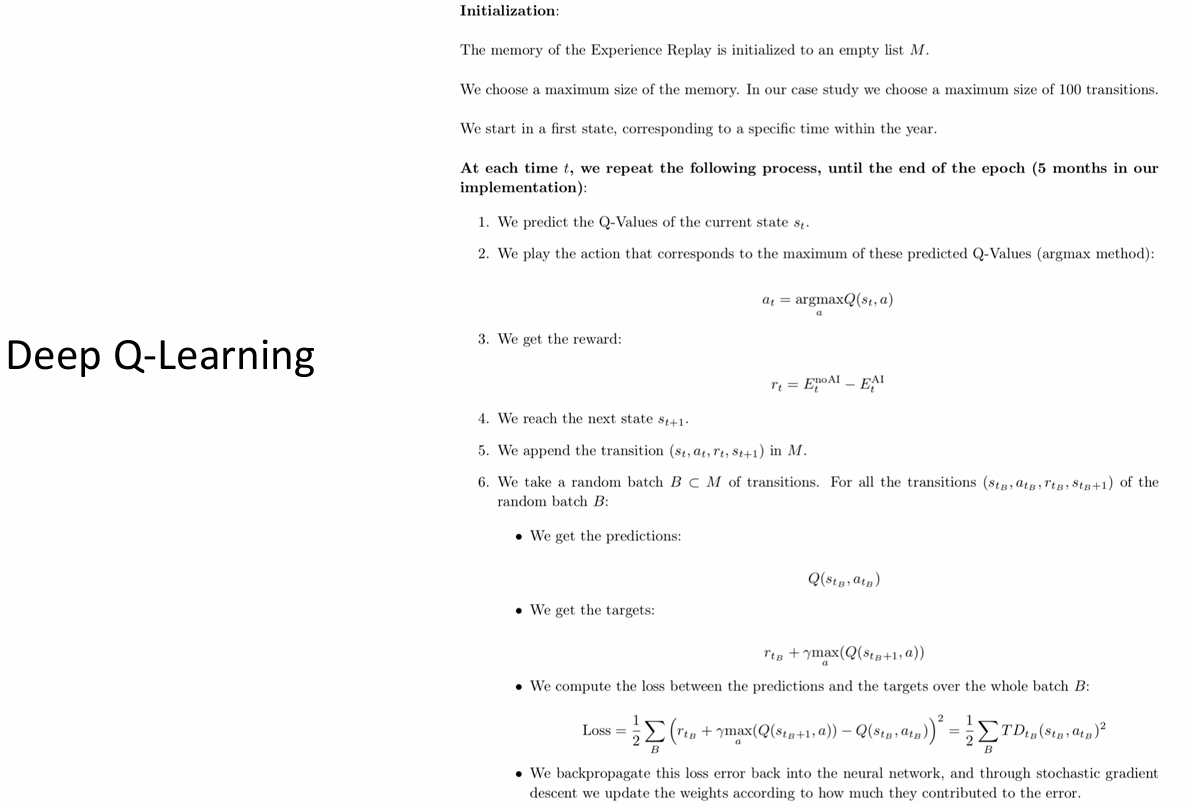

In [3]:
import numpy as np

class DQN(object):

    # CRIAÇÃO E INICIALIZAÇÃO DOS PARÂMETROS E VARIÁVEIS DO DQN
    def __init__(self, max_memory=100, discount=0.9):
        self.memory = list()
        self.max_memory = max_memory
        self.discount = discount
    
    # CRIAÇÃO DA MEMÓRIA PARA A EXPERIÊNCIA DE REPLAY
    def remember(self, transition, game_over):
        self.memory.append((transition, game_over))
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    # CRIAÇÃO DE DOIS BATCHS DE INPUTS E TARGETS EXTRAINDO TRANSIÇÕES DA MEMÓRIA
    def get_batch(self, model, batch_size=10):
        len_memory = len(self.memory)
        num_inputs = self.memory[0][0][0].shape[1]
        num_outputs = model.output_shape[-1]
        inputs = np.zeros((min(len_memory, batch_size), num_inputs))
        targets = np.zeros((min(len_memory, batch_size), num_outputs))
        for i, idx_tran in enumerate(np.random.randint(0, len_memory, size=min(len_memory, batch_size))):
            current_state, action, reward, next_state = self.memory[idx_tran][0]
            game_over = self.memory[idx_tran][1]
            inputs[i] = current_state
            targets[i] = model.predict(current_state, verbose=0)[0]
            q_sa = np.max(model.predict(next_state, verbose=0)[0])
            if game_over:
                targets[i, action] = reward
            else:
                targets[i, action] = reward + self.discount * q_sa
        return inputs, targets

In [ ]:
import os
import random as rn
import numpy as np

# Configuração do seed para reproducibilidade
os.environ["PYTHONHASHSEED"] = "0"
np.random.seed(42)
rn.seed(12345)

# CONFIGURAÇÃO DOS PARÂMETROS
epsilon = 0.3
number_actions = 5
direction_boundary = (number_actions - 1) / 2
number_epochs = 100
max_memory = 3000
batch_size = 512
temperature_step = 1.5

# EVITAR O OVERFITTING (SUPER AJUSTE)
early_stopping = True
patience = 10
best_total_reward = -np.inf
patience_count = 0

# CRIAÇÃO DO AMBIENTE
env = Environment(optimal_temperature=(18.0, 24.0), initial_month=0,
                  initial_number_users=20, initial_rate_data=30)

# CRIAÇÃO DO CÉREBRO (REDE NEURAL)
brain = Brain(learning_rate=0.00001, number_actions=number_actions)

# CRIAÇÃO DO DEEP Q-LEARNING
dqn = DQN(max_memory=max_memory, discount=0.9)

# DEFINIÇÃO DO MODO DE TREINAMENTO/TESTE
train = True

# TREINAMENTO DA INTELIGÊNCIA ARTIFICIAL
env.train = train
model = brain.model

def egreedy_action_selection(action, direction_boundary, temperature_step):
    if action - direction_boundary < 0:
        direction = -1
    else:
        direction = 1
    energy_ai = abs(action - direction_boundary) + temperature_step
    return direction, energy_ai

if env.train:
    # COMEÇANDO O LOOP QUE PERCORRERÁ TODAS AS ÉPOCAS (1 ÉPOCA = 5 MESES)
    for epoch in range(1, number_epochs+1):
        # INICIALIZAÇÃO DAS VARIÁVEIS DE AMBIENTE E DO LOOP
        total_reward = 0
        loss = 0
        new_month = np.random.randint(0, 12)
        env.reset(new_month)
        game_over = False
        current_state, _, _ = env.observe()
        timestep = 0

        # COMEÇANDO O LOOP QUE PERCORRERÁ CADA TIMESTEP (1 TIMESTEP = 1 MINUTO)
        while not game_over and timestep <= 5 * 30 * 24 * 60:
            # EXECUÇÃO DA PRÓXIMA AÇÃO COM EXPLORAÇÃO
            if np.random.rand() <= epsilon:
                action = np.random.randint(0, number_actions)
                direction, energy_ai = egreedy_action_selection(action, direction_boundary, temperature_step)
            # EXECUÇÃO DA PRÓXIMA AÇÃO POR INFERÊNCIA, USANDO A REDE NEURAL
            else:
                q_values = model.predict(current_state, verbose=0)
                action = np.argmax(q_values[0])
                direction, energy_ai = egreedy_action_selection(action, direction_boundary, temperature_step)

            # ATUALIZAÇÃO DO AMBIENTE E OBTENDO O NOVO ESTADO
            minute_to_month = int(timestep / (30 * 24 * 60))
            next_state, reward, game_over = env.update_env(direction, energy_ai, minute_to_month)
            total_reward += reward
            
            # ARMAZENAMENTO DA NOVA TRANSIÇÃO NA MEMÓRIA
            dqn.remember((current_state, action, reward, next_state), game_over)

            # SEPARAÇÃO EM DOIS BATCHS (INPUTS E TARGETS)
            inputs, targets = dqn.get_batch(model, batch_size=batch_size)

            # CÁLCULO DO ERRO (LOSS) USANDO OS BATCHS
            loss += model.train_on_batch(inputs, targets)
            timestep += 1
            current_state = next_state

        # IMPRESSÃO DOS RESULTADOS DO TREINAMENTO PARA CADA ÉPOCA
        print("\n")
        print("Epoch: {:03d}/{:03d}".format(epoch, number_epochs))
        print("Total enery spent with AI: {:.0f}".format(env.total_energy_ai))
        print("Total enery spent with no AI: {:.0f}".format(env.total_energy_noai))

        # EARLY STOPPING MANUAL
        if early_stopping:
            if total_reward <= best_total_reward:
                patience_count += 1
            elif total_reward > best_total_reward:
                best_total_reward = total_reward
                patience_count = 0

            if patience_count > patience:
                print("Early stopping...")
                break

        if epoch % 5 == 0:
            model.save(f"model_server_cost_{epoch}.h5")

    # SALVA O MODELO
    model.save("model_server_cost.h5")



Epoch: 001/100
Total enery spent with AI: 76
Total enery spent with no AI: 115


Epoch: 002/100
Total enery spent with AI: 149
Total enery spent with no AI: 155


Epoch: 003/100
Total enery spent with AI: 126
Total enery spent with no AI: 168


Epoch: 004/100
Total enery spent with AI: 97
Total enery spent with no AI: 140


Epoch: 005/100
Total enery spent with AI: 87
Total enery spent with no AI: 100


In [ ]:
from keras.models import load_model

number_actions = 5
direction_boundary = (number_actions - 1) / 2
temperature_step = 1.5

# CRIAÇÃO DO AMBIENTE
env = Environment(optimal_temperature=(18.0, 24.0), initial_month=0,
                  initial_number_users=20, initial_rate_data=30)

# CARREGAMENTO DO MODELO
model = load_model("model_server_cost.h5")

# TESTE DA INTELIGÊNCIA ARTIFICIAL (SIMULAÇÃO DE 1 ANO)
train = False
env.train = train
current_state, _, _ = env.observe()

def egreedy_action_selection(action, direction_boundary, temperature_step):
    if action - direction_boundary < 0:
        direction = -1
    else:
        direction = 1
    energy_ai = abs(action - direction_boundary) + temperature_step
    return direction, energy_ai

minutes_1_year = 12 * 30 * 24 * 60
for timestep in rnage(0, minutes_1_year):
    # EXECUÇÃO DA PRÓXIMA AÇÃO POR INFERÊNCIA, USANDO A REDE NEURAL
    q_values = model.predict(current_state, verbose=0)
    action = np.argmax(q_values[0])
    direction, energy_ai = egreedy_action_selection(action, direction_boundary, temperature_step)

    # ATUALIZAÇÃO DO AMBIENTE E OBTENDO O NOVO ESTADO
    minute_to_month = int(timestep / (30 * 24 * 60))
    next_state, reward, game_over = env.update_env(direction, energy_ai, minute_to_month)
    current_state = next_state

# IMPRESSÃO DOS RESULTADOS
print("\n")
print("Total enery spent with AI: {:.0f}".format(env.total_energy_ai))
print("Total enery spent with no AI: {:.0f}".format(env.total_energy_noai))
print("ENERGY SAVED: {:.0f}%".format((env.total_energy_noai - env.total_energy_ai) / env.total_energy_noai * 100)